In [1]:
using LinearAlgebra, Plots, PGFPlotsX, LaTeXStrings, KernelEstimator, ProgressBars
pgfplotsx()

Plots.PGFPlotsXBackend()

In [2]:
using NBInclude
@nbinclude("Data_generation.ipynb")
@nbinclude("Barycenter_algorithms.ipynb")

barycenter_functional (generic function with 1 method)

In [3]:
function median_objective(covs, sqrt_covs, X, ϵ)
    d = size(covs)[1]
    n = size(covs)[3]
    evals = zeros(d)
    evecs = zeros(d, d)
    
    result = 0
    for j in 1:n
        sq = @view sqrt_covs[:,:,j]

        e = eigen(Symmetric(sq*X*sq))
        evals .= e.values
        evecs .= e.vectors
        
        result += sqrt(max(0,real(ϵ^2 + bures(sqrt_covs[:,:,j], X))))
    end
    return result/n
end
    

function medianGD(covs, sqrt_covs, X, nIter, ϵ, times, objective; η=1, eps_metric = false)
    d = size(covs)[1]
    n = size(covs)[3]
    # Cache variables for memory efficiency. T refers to transport map
    T̃ = zeros(d,d)
    T = zeros(d,d)
    evals = zeros(d)
    evecs = zeros(d,d)
    
    start = time()
    for i in 1:nIter
        T̃ .= zeros(d,d)
        T .= zeros(d,d)
        

        for j in 1:n
            sq = @view sqrt_covs[:,:,j]

            e = eigen(Symmetric(sq*X*sq))
            evals .= e.values
            evecs .= e.vectors
            T .= sq*evecs*diagm(evals.^(-0.5))*evecs'*sq
            T̃ .= T̃ .+ (T .- I(d))./ sqrt(ϵ^2 + bures(sqrt_covs[:,:,j], X))
        end
        
        T̃ .= I(d) + T̃ .* η*ϵ ./ n
        objective[i] = median_objective(covs, sqrt_covs, X, eps_metric ? ϵ : 0)
        X .= Symmetric(T̃ *X *T̃)
        times[i] = time() - start
    end
end

function median_EGD!(covs, sqrt_covs, X, nIter, ϵ, times, objectives, α, β; η = 1, eps_metric = false)
    d = size(covs)[1]
    n = size(covs)[3]
    # Cache variables for memory efficiency. T refers to transport map
    T̃ = zeros(d,d)
    T = zeros(d,d)
    evals = zeros(d)
    evecs = zeros(d,d)
    
    start = time()
    for i in 1:nIter
        T̃ .= zeros(d,d)
        T .= zeros(d,d)
        

        for j in 1:n
            sq = @view sqrt_covs[:,:,j]

            e = eigen(Symmetric(sq*X*sq))
            evals .= e.values
            evecs .= e.vectors
            T .= sq*evecs*diagm(evals.^(-0.5))*evecs'*sq
            T̃ .= T̃ .+ (T .- I(d))./ sqrt(ϵ^2 + bures(sqrt_covs[:,:,j],X))
        end
        
        objectives[i] = median_objective(covs, sqrt_covs, X, eps_metric ? ϵ : 0)
        X .= Symmetric(X .+ η .* T̃ ./ n)
        clip!(X, α, β)
        times[i] = time() - start
    end
end


median_EGD! (generic function with 1 method)

# Median at different accuracies (Figure 5)

## Setting parameters (see paper for parameters used for figures)

In [4]:
n = 30
d = 30
α = .01
β = 10
κ = 1000
nIter = 14000
ϵs = [100, 1, 0.1, 0.01];

In [5]:
times = zeros(nIter, length(ϵs))
objectives = zeros(nIter, length(ϵs))

X = zeros(d,d,length(ϵs))
covs = zeros(d,d,n)
sqrt_covs = zeros(d,d,n)
gen1(covs, sqrt_covs, α, β)


for i in ProgressBar(1:length(ϵs))
    ϵ = ϵs[i]
    X[:,:,i] .= covs[:,:,1]
    XX = @view X[:,:,i]
    
    tim = @view times[:, i]
    obj = @view objectives[:, i]
    
    medianGD(covs, sqrt_covs, XX, nIter, ϵ, tim, obj, eps_metric=false)
end

0.0%┣                                            ┫ 0/4 [00:00<00:00, -20.0 it/s]
25.0%┣██████████▊                                ┫ 1/4 [09:43<Inf:Inf, 0.0 it/s]
50.0%┣██████████████████████▌                      ┫ 2/4 [14:59<29:59, 0.0 it/s]
75.0%┣█████████████████████████████████▊           ┫ 3/4 [20:15<10:08, 0.0 it/s]
100.0%┣████████████████████████████████████████████┫ 4/4 [25:36<00:00, 0.0 it/s]
100.0%┣████████████████████████████████████████████┫ 4/4 [25:36<00:00, 0.0 it/s]



In [6]:
logres = log10.(max.(1e-15, objectives .- minimum(objectives)))
smoothed = zeros(size(logres))
for i in 1:length(ϵs)
    bw = bwlscv(times[:,i], gaussiankernel)
    smoothed[:, i] = KernelEstimator.npr(times[:,i], logres[:, i], kernel=gaussiankernel, reg=locallinear, h = bw)
end

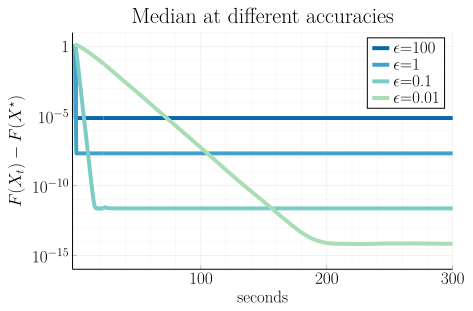

In [7]:
plt = plot(color_palette=palette(:GnBu_6), 
    title = L"\textrm{Median at different accuracies}",
    ylabel = L"F(X_t) - F(X^\star)",
    xlabel = "seconds",
    legend=:topright, 
    minorgrid = true, 
    legendfontsize=17,
    tickfontsize=17,
    labelfontsize=17, 
    titlefontsize=22)
linecolor = [6 5 4 3 2]
for i in 1:length(ϵs)
    plot!(times[1:1000,i], logres[1:1000,i], 
          labels = string("ϵ=", string(ϵs[i] == Int(floor(ϵs[i])) ? Int(floor(ϵs[i])) : ϵs[i])), 
          linecolors = linecolor[i], 
          linewidth = 4)
    plot!(times[1001:end,i], smoothed[1001:end,i], 
          labels = nothing, 
          linecolors = linecolor[i], 
          linewidth = 4)
end
xlims!(-2,300)
ylims!(-16,1)
xticks!([100, 200, 300])
yticks!([-15,-10,-5, 0], ["10^{-15}", "10^{-10}", "10^{-5}", "1"])
display(plt)

In [ ]:
savefig(plt, "./figures/Median-accuracies")

# Robustness of median (Figure 6)

## Setting parameters (see paper for parameters used for figures)

In [8]:
n = 20
d = 20
α = 1
β = 10
ϵ = .1
fracs = [.2, .45, .55];

In [9]:
covs = zeros(d,d,n)
sqrt_covs = zeros(d,d,n)

gen1(covs, sqrt_covs, α, β)

nIter = 6000

true_median = zeros(d,d)
true_bary = zeros(d,d)
true_median .= covs[:,:,1]
placeholder = zeros(nIter)

medianGD(covs, sqrt_covs, true_median, nIter, ϵ, placeholder, placeholder)
true_bary = GD!(nIter, covs, sqrt_covs, placeholder, placeholder, 1, placeholder, covs[:,:,1])

true_median .= true_median^.5
true_bary .= true_bary^.5

perturbation = LinRange(1, 50, 6)
X = zeros(d, d)
sqrt_X_bary = zeros(d, d)
diffs = zeros(length(fracs), length(perturbation), 2)

fake_covs = zeros(d,d,n)
fake_sqrt_covs = zeros(d,d,n)


for j in ProgressBar(1:length(fracs))
    frac = fracs[j]
    
    for i in 2:length(perturbation)
        p = perturbation[i]
        
        for k in 1:n
            fake_covs[:,:,k] .= covs[:,:,k]
            fake_sqrt_covs[:,:,k] .= sqrt_covs[:,:,k]
            if k <= frac*n
                fake_covs[:,:,k] .*= p
                fake_sqrt_covs[:,:,k] .*= sqrt(p)
            end 
        end
        
        X .= fake_covs[:,:,1]
        sqrt_X_bary .= fake_covs[:,:,1]
#         obj = @view objective[i, :]
        medianGD(fake_covs, fake_sqrt_covs, X, nIter, ϵ, placeholder, placeholder)
        sqrt_X_bary .= GD!(nIter, fake_covs, fake_sqrt_covs, placeholder, placeholder, 1, placeholder, covs[:,:,1])
        diffs[j, i, 1] = bures(true_median, X)
        diffs[j, i, 2] = bures(true_bary, sqrt_X_bary^2)    
    end
end

0.0%┣                                            ┫ 0/3 [00:00<00:00, -20.0 it/s]
33.3%┣██████████████▍                            ┫ 1/3 [04:14<Inf:Inf, 0.0 it/s]
66.7%┣██████████████████████████████               ┫ 2/3 [08:26<08:26, 0.0 it/s]
100.0%┣████████████████████████████████████████████┫ 3/3 [12:37<00:00, 0.0 it/s]
100.0%┣████████████████████████████████████████████┫ 3/3 [12:37<00:00, 0.0 it/s]



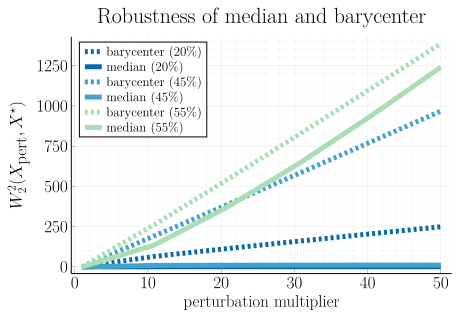

In [10]:
plt = plot(color_palette=palette(:GnBu_6), 
    title = "Robustness of median and barycenter",
    ylabel = L"W_2^2(X_\textrm{pert}, X^\star)",
    xlabel = "perturbation multiplier",
    legend=:topright, 
    minorgrid = true, 
    legendfontsize=17,
    tickfontsize=17,
    labelfontsize=17, 
    titlefontsize=22)
linecolors = [6 5 3]
for i in 1:length(fracs)
    plot!(perturbation, diffs[i, :, 2], 
        label="barycenter ($(Int(floor(fracs[i]*100)))%)", 
        linecolor=linecolors[i], 
        linestyle=:dash, 
        linewidth = 5)
    plot!(perturbation, diffs[i, :, 1], linecolor=linecolors[i],
        linewidth = 5,  
        legend=:topleft,
        minorgrid=true,
        labels = "median ($(Int(floor(fracs[i]*100)))%)",
        legendfontsize=13,
        fontfamily = "New Century Schoolbook Roman")
end
display(plt)

In [ ]:
savefig(plt, "./figures/median-robustness")